In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret

data_path = 'C:/ML/datasets/data_f_60mm_good.mat'
# data_path = 'C:/ML/datasets/data_base_CP_CL_f_60mm_2_cameras_6_6.mat'

In [2]:
CL = loadmat(data_path)['CL']
CP = loadmat(data_path)['CP']

print(len(CL), len(CL[0]), CL[0][0].shape)
print(len(CP), len(CP[0]), CP[0][0].shape)

1 100 (512, 512)
1 100 (801, 801)


(2513, 2513) 33.11300634363737
(2513, 2513) 183162190.0
1.0 0.9999996


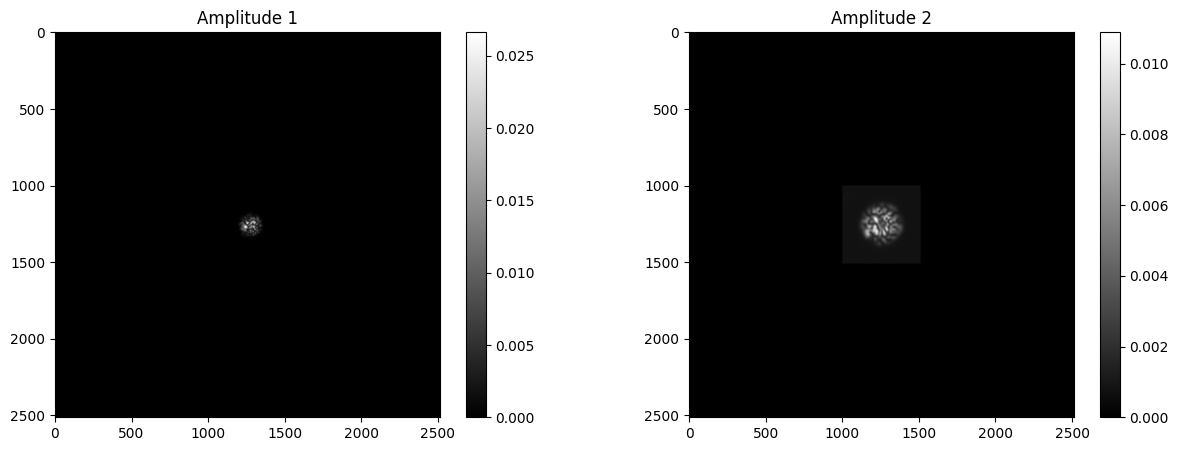

In [54]:
idx = 10
size = 256
start = 270
output_field = CP[0][idx]#[start:start+size, start:start+size]
output_field = speckleret.transforms.pad_img(output_field, 2.139)
output_field_energy = np.sum(np.square(np.abs(output_field)))
output_field = output_field / np.sqrt(output_field_energy)
print(output_field.shape, output_field_energy)

fresnel_intens = np.sqrt(CL[0][idx])
fresnel_intens = fresnel_intens[:-1,:-1]
fresnel_intens = speckleret.transforms.pad_img(fresnel_intens, 3.92)

fresnel_intens_energy = np.sum(np.square(np.abs(fresnel_intens)))
fresnel_intens = fresnel_intens / np.sqrt(fresnel_intens_energy)
print(fresnel_intens.shape, fresnel_intens_energy)

normalized_output_field_energy = np.sum(np.square(np.abs(output_field)))
normalized_fresnel_intens_energy = np.sum(np.square(np.abs(fresnel_intens)))
print(normalized_output_field_energy, normalized_fresnel_intens_energy)

_ = speckleret.plots.compare_arrays(output_field, fresnel_intens, cmap='gray')

(2513, 2513, 3)


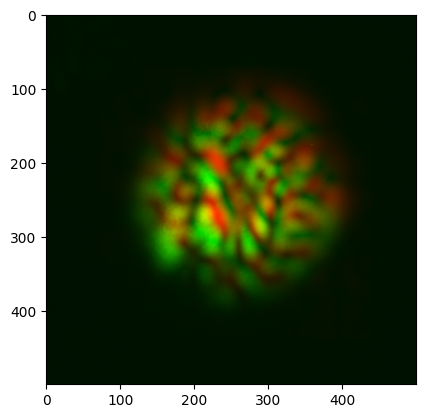

In [71]:
ff_field = speckleret.transforms.fourier_transform(output_field)
# _ = speckleret.plots.compare_arrays(np.abs(ff_field), fresnel_intens, cmap='gray')

r = np.abs(ff_field) / np.max(np.abs(ff_field))
g = np.abs(fresnel_intens) / np.max(np.abs(fresnel_intens))
b = np.zeros_like(r)
img = np.dstack((r, g, b))
print(img.shape)
plt.imshow(img[1000:1500, 1000:1500])
plt.show()

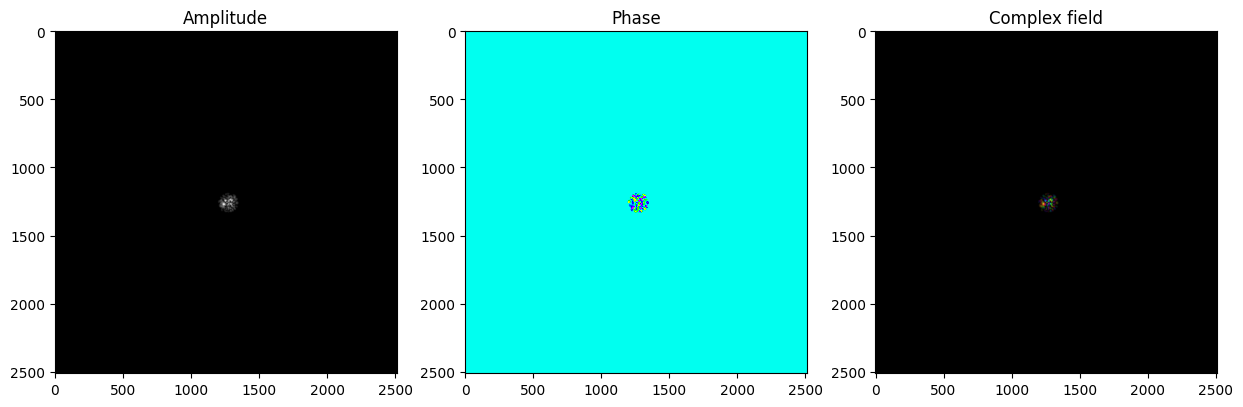

In [72]:
support = speckleret.supports.threshold_support(output_field, threshold=0.005)
supported_field = output_field.copy()
supported_field[np.logical_not(support)] = 0
_ = speckleret.plots.complex_imshow(supported_field)

1 / 2
2 / 2
Quality: 0.006324684382080076
Pearson: 1.0000000000000002


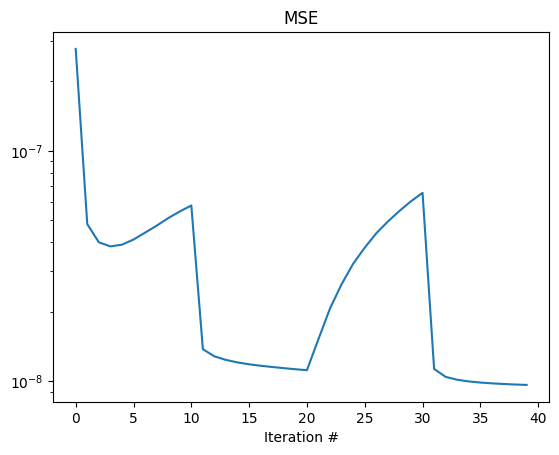

In [73]:
# ft = speckleret.transforms.fourier_transform(output_field, pad=1.4)
# y_hat, ft_hat, results = speckleret.retrieval.hio_er_fourier((np.abs(output_field), np.abs(ft)), support, pad=1.4, beta=0.99, max_iter=2, max_er_iter=200, max_hio_iter=150)
y_hat, ft_hat, results = speckleret.retrieval.hio_er_fourier((np.abs(output_field), np.abs(fresnel_intens)), support, pad=None, beta=0.99, max_iter=2, max_er_iter=10, max_hio_iter=10)
# y_hat, ft_hat, results = speckleret.retrieval.hio_fourier((np.abs(output_field), np.abs(fresnel_intens)), support, pad=None, beta=0.99, max_iter=100)
# y_hat, ft_hat, results = speckleret.retrieval.hio_gs_fourier((np.abs(output_field), np.abs(ft)), support, pad=1.4, beta=0.99, max_iter=3, max_er_iter=200, max_hio_iter=150)

y_hat[np.logical_not(support)] = 0
print(f"Quality: {speckleret.metrics.quality(y_hat[support], output_field[support])}")
print(f"Pearson: {speckleret.metrics.pearson(y_hat[support], output_field[support])}")

plt.figure()
plt.plot(results['mse_plane2'], label='Fourier MSE')
plt.title('MSE')
plt.xlabel('Iteration #')
plt.yscale('log')

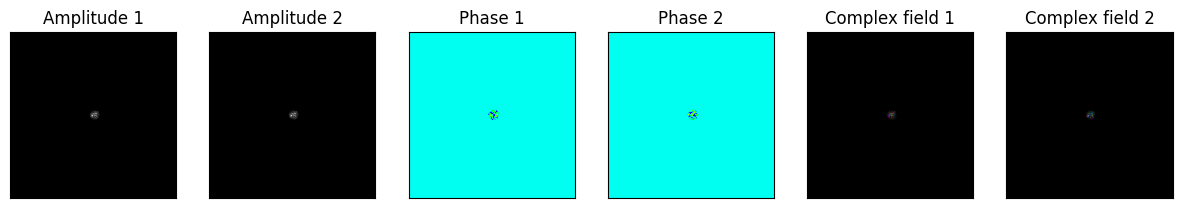

In [75]:
_ = speckleret.plots.compare_complex_fields(supported_field[100:1500, 1000:1500], y_hat[100:1500, 1000:1500], remove_ticks=True)